# Part I
## 1-3

In [156]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoLarsCV, LinearRegression, LogisticRegression, ElasticNet, Lasso, SGDClassifier, \
    SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

Users
------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BrukerID  6040 non-null   int64  
 1   Kjonn     5737 non-null   float64
 2   Alder     5046 non-null   float64
 3   Jobb      5447 non-null   float64
 4   Postkode  5589 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 236.1 KB
None



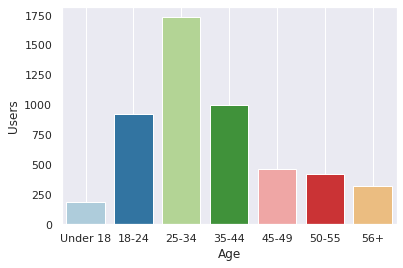

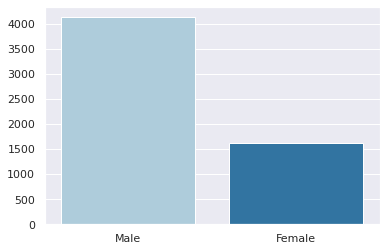

In [157]:
from sklearn.neural_network import MLPClassifier
sns.set_theme(style="darkgrid",palette="Paired")

user_df = pd.read_csv ('clean_data/bruker.csv')
movies_df = pd.read_csv ('clean_data/film.csv')
rank_df = pd.read_csv ('clean_data/rangering.csv')

print("Users")
print("------------------\n")
print(user_df.info())
print()

user_count= user_df["Alder"].value_counts()
groups_int= [1,18,25,35,45,50,56]
groups = ["Under 18","18-24","25-34","35-44","45-49","50-55","56+"]
values = [user_count[x] for x in groups_int]
sns.barplot(x=groups,y=values)
plt.grid()
plt.xlabel("Age")
plt.ylabel("Users")
plt.show()

plt.figure(2)

sns.barplot(x=["Male","Female"],y=[user_df["BrukerID"][(user_df['Kjonn'] == 1)].count(), user_df["BrukerID"][(user_df['Kjonn'] == 0)].count()])
plt.show()

Movies
------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   FilmID       3883 non-null   int64 
 1   Tittel       3883 non-null   object
 2   Aar          3883 non-null   int64 
 3   Action       3883 non-null   int64 
 4   Adventure    3883 non-null   int64 
 5   Animation    3883 non-null   int64 
 6   Children's   3883 non-null   int64 
 7   Comedy       3883 non-null   int64 
 8   Crime        3883 non-null   int64 
 9   Documentary  3883 non-null   int64 
 10  Drama        3883 non-null   int64 
 11  Fantasy      3883 non-null   int64 
 12  Film-Noir    3883 non-null   int64 
 13  Horror       3883 non-null   int64 
 14  Musical      3883 non-null   int64 
 15  Mystery      3883 non-null   int64 
 16  Romance      3883 non-null   int64 
 17  Sci-Fi       3883 non-null   int64 
 18  Thriller     3883 non-null   int64 
 19  

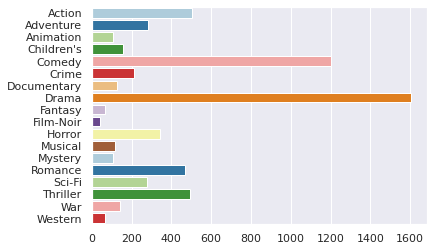

In [158]:
print("Movies")
print("------------------\n")
print(movies_df.info())
print()

categories = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
categories_count = [movies_df[x].value_counts()[1] for x in categories]

sns.barplot(y=categories, x=categories_count, orient='h',palette="Paired")
plt.show()

In [159]:
print("Rankings")
print("------------------\n")
print(rank_df.info())
print()
sns.set_theme(style="darkgrid")
sns.set_palette(palette="Paired")

rank_df['Tidstempel'] = pd.to_datetime(rank_df['Tidstempel'],unit='s')
movie_count = rank_df["FilmID"].value_counts()

Rankings
------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900188 entries, 0 to 900187
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BrukerID    900188 non-null  int64  
 1   FilmID      900188 non-null  int64  
 2   Rangering   900188 non-null  int64  
 3   Tidstempel  898696 non-null  float64
 4   Kveldstid   900188 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 34.3 MB
None



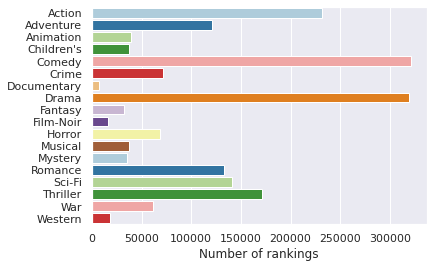

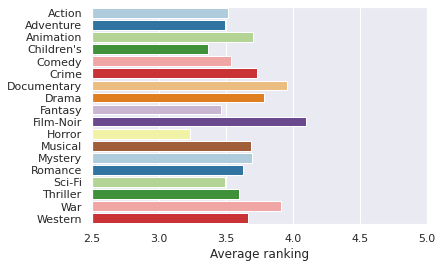

In [160]:
sns.set_theme(style="darkgrid")
sns.set_palette(palette="Paired")

result_df = pd.merge(movies_df, rank_df)

categories = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
result_count = [result_df[x].value_counts()[1] for x in categories]

sns.color_palette("Paired")
#sns.jointplot(y=categories,x=result_count,hue=categories)
sns.barplot(y=categories,x=result_count,orient='h',palette="Paired")
plt.xlabel("Number of rankings")
plt.show()

plt.figure(2)
result_mean= [result_df[result_df[x]==1]["Rangering"].mean() for x in categories]
sns.barplot(y=categories,x=result_mean,orient='h',palette="Paired")
plt.xlim(2.5,5)
plt.xlabel("Average ranking")

plt.show()


In [161]:
## Baseline recommender
countdf= rank_df['FilmID'].value_counts()>=20
reduced_rank_df = rank_df[['FilmID','Rangering']].groupby('FilmID').mean()[countdf]
# This list contains all movies rated by over 20 users with an average over 4
# Choose 20 of these when recommending
baseline = reduced_rank_df.loc[reduced_rank_df['Rangering'] > 4].index.to_numpy()


<ipython-input-161-b0f62a4481bf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reduced_rank_df = rank_df[['FilmID','Rangering']].groupby('FilmID').mean()[countdf]


Splitting the data set accordingly:

Training: 70%
Validation: 15%
Test: 15%


In [162]:
# Creating a complete dataframe(df) joining the three csv files.
df_1 = pd.read_csv ('clean_data/bruker.csv')
df_2 = pd.read_csv ('clean_data/rangering.csv')
df_3 = pd.read_csv('clean_data/film.csv')
df_4 = pd.merge(df_1,df_2, on="BrukerID")
df = pd.merge(df_4,df_3, on="FilmID")

df = df.sample(1000)

In [163]:
def preprocess(df,X_columns):

    df['Postkode'].fillna(0)
    y = df["Rangering"].copy()
    X = df[X_columns].copy()

    cols = X.loc[:,['Kjonn','Alder','Jobb','Postkode']]
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(cols)
    X[['Kjonn','Alder','Jobb','Postkode']] = imputer.transform(cols)

    #Splitting into train, validation and test
    r = 43
    X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=r)
    X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=r)

    print("--- Done preparing data ---")
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = preprocess(df,['BrukerID','Kjonn', 'Alder', 'Jobb', 'Postkode',"FilmID","Aar","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"])

--- Done preparing data ---


In [167]:
# Content-based model using regression
# Testing and comparing several different regressors
l = LinearRegression()
en = ElasticNet()
la = Lasso()
lal = LassoLarsCV(cv=10)
sgdc = SGDClassifier()
sgdr = SGDRegressor()
lr1 = LogisticRegression(penalty="l2", solver="newton-cg")
lr2 = LogisticRegression(solver='sag')
le3 = LogisticRegression(solver='saga')
rfr = RandomForestRegressor(warm_start=True)
clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(8,2), random_state=42)

# Train the models on data, then validate and test
models = [l, en, la, lal, sgdc, sgdr,lr1,lr2,le3,rfr,clf]


def run_model(reg,X_train,y_train,X_val,y_val,X_test,y_test):
    print('\n')
    print(print(reg))
    print("-------------------------\n")
    reg.fit(X=X_train, y=y_train)

    #mean squared errors
    y_pred_train=reg.predict(X_train)
    MSE_train=mean_squared_error(y_train, y_pred_train)

    y_pred_val=reg.predict(X_val)
    MSE_val=mean_squared_error(y_val, y_pred_val)

    print('MSE on training data: ', MSE_train)
    print('MSE on validating data: ', MSE_val)

    #generalization/prediction for new data (test data)
    y_pred_logreg=reg.predict(X_test)

    #compute the root mean squared error
    MSE_test=mean_squared_error(y_test, y_pred_logreg)
    RMSE=np.sqrt(MSE_test)

    print('RMSE on test data:', RMSE)


for x in models:
    run_model(model,X_train,y_train,X_val,y_val,X_test,y_test)

# I choose XXXX as my model because it has the lowest



LogisticRegression(max_iter=1000, solver='newton-cg')
None
-------------------------

MSE on training data:  1.6014285714285714
MSE on validating data:  2.013333333333333
RMSE on test data: 1.451436070471816


LogisticRegression(max_iter=1000, solver='newton-cg')
None
-------------------------

MSE on training data:  1.6014285714285714
MSE on validating data:  2.013333333333333
RMSE on test data: 1.451436070471816


LogisticRegression(max_iter=1000, solver='newton-cg')
None
-------------------------

MSE on training data:  1.6014285714285714
MSE on validating data:  2.013333333333333
RMSE on test data: 1.451436070471816


LogisticRegression(max_iter=1000, solver='newton-cg')
None
-------------------------

MSE on training data:  1.6014285714285714
MSE on validating data:  2.013333333333333
RMSE on test data: 1.451436070471816


LogisticRegression(max_iter=1000, solver='newton-cg')
None
-------------------------

MSE on training data:  1.6014285714285714
MSE on validating data:  2.013

/home/elias/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/elias/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/elias/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/elias/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/elias/.local/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did 

KeyboardInterrupt: 

In [165]:
#Collaborative recommender model
#This model consist of a cosine similarity table of the ratings of each user (line) for each movie (column), and fill with 0.0 the ones tha haven't been rated
rank_df = pd.read_csv("clean_data/rangering.csv")
ratings_matrix = rank_df.pivot_table(index="FilmID",columns="BrukerID",values='Rangering').fillna( 0)

#computing the cosine similarity, which express the correlation between a movie j and another movie k
movie_similarity=cosine_similarity(ratings_matrix)
#we fill with the value 0 the similarity of a user with itself, so that the system would not recommend the same user
np.fill_diagonal(movie_similarity, 0 )

In [166]:
# Save model
'''
pickle.dump({
    'cosine_similarity': movie_similarity,
    'ratings_matrix': ratings_matrix,
    'imputer': imputer,
    'model': reg,
    'baseline': baseline},
    open('model.pkl', 'wb'))
'''


"\npickle.dump({\n    'cosine_similarity': movie_similarity,\n    'ratings_matrix': ratings_matrix,\n    'imputer': imputer,\n    'model': reg,\n    'baseline': baseline},\n    open('model.pkl', 'wb'))\n"

## Experimentation with pytorch and fastai library

```python
import fastai
import torch

data = CollabDataLoaders.from_df(df, seed=42, valid_pct=0.1, item_name='Tittel')

data.show_batch()

y_range = [1,5]
learn = collab_learner(data, y_range=y_range)
learn.lr_find()
learn.fine_tune(5)
learn.show_results()
```